In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
%load_ext rpy2.ipython

In [3]:
import os
import numpy as np
import pandas as pd
import dual_crispr_screen
import imp
imp.reload(dual_crispr_screen)



<module 'dual_crispr_screen' from '/cellar/users/samsonfong/crappy/src/dual_crispr_screen.py'>

In [4]:
# Global parameters

BASE = os.path.realpath('../')
TEST_SET = os.path.join(BASE, 'data', 'test_data','input_data', 'TestSet8')

# Test Set

In [5]:
abundance_file = os.path.join(TEST_SET, "TestSet8_abundance_thresholds.txt")
counts_file = os.path.join(TEST_SET, "TestSet8_timepoint_counts.txt")

#abundance_file = "/cellar/users/bpmunson/crappy/data/test_data/input_data/TestSet8/TestSet8_abundance_thresholds.txt"
#counts_file = "/cellar/users/bpmunson/crappy/data/test_data/input_data/TestSet8/TestSet8_timepoint_counts.txt"
times = np.array([21,28])

# initialize screen object
screen = dual_crispr_screen.Screen(counts_file, times, abundance_file)

# set some parameters
# number of iterations to perform
screen.options.niter = 2
screen.options.testing = True
screen.options.null_target_id = '0'
screen.options.verbose = True

# perform construct fitness calculation
screen.run_construct_fitting()

# run bootstraps
screen.run_bootstrap()

# summarize results 
screen.summarize()

# view results 
screen.results.head()

hi
               log2CountsThresh
sampleName                     
A549CV4_T21_1             4.525
A549CV4_T21_2             4.325
A549CV4_T28_1             3.925
A549CV4_T28_2             3.475
[[[-18.4583628  -19.32780328]]

 [[-18.66790896 -19.97675167]]]


/cellar/users/samsonfong/crappy/src/fit_ac_fc.py:257: RuntimeWarning: invalid value encountered in true_divide
  fc = np.divide(f.sum(axis=0), var_time.sum(axis=0))
/cellar/users/samsonfong/crappy/src/fit_ac_fc.py:283: RuntimeWarning: invalid value encountered in true_divide
  sdfc = np.divide(num, denom).data


Iter	RMS	Relative Error
1	0.0227	0.058415
2	0.0219	0.030430
3	0.0215	0.016396
4	0.0213	0.009132
5	0.0211	0.005257
6	0.0211	0.003128
7	0.0210	0.001920
8	0.0210	0.001211
9	0.0210	0.000783
Performing iteration: 1
Iter	RMS	Relative Error
1	0.0014	0.084903
2	0.0010	0.008124
3	0.0009	0.000827
Performing iteration: 2
Iter	RMS	Relative Error
1	0.0013	0.083478
2	0.0010	0.008159
3	0.0009	0.000923


/cellar/users/samsonfong/crappy/src/bootstrap_pi.py:274: RuntimeWarning: divide by zero encountered in true_divide
  fdr_right = np.minimum(1, enull(-pi_mean)/(1-emean(pi_mean)))


,geneA,geneB,pi_mean,fdr_left,fdr_right,sd,z,pp,fA,fB
0,0,ABL1,-0.016598,0.520198,1.0,0.025642,-0.646978,0.0,-0.000108,0.000593
1,0,ADA,0.016067,0.936011,1.0,0.022820,0.626272,0.0,-0.000108,0.001239
2,0,AKT1,-0.014196,0.555413,1.0,0.023174,-0.553338,0.0,-0.000108,0.000690
3,0,ALK,-0.001825,0.699888,1.0,0.005062,-0.071121,0.0,-0.000108,0.000725
4,0,APC,-0.029941,0.432203,1.0,0.044673,-1.167065,0.0,-0.000108,0.000575


In [6]:
### Compare to CTG benchmark pi scores

In [7]:
#benchmark = "/cellar/users/bpmunson/crappy/data/test_data/output_data/Notebook8Test_pi.txt"
benchmark = os.path.join(BASE, 'data', 'test_data', 'output_data', 'Notebook8Test_pi.txt')

benchmark = pd.read_csv(benchmark, sep="\t", header=0)
benchmark_pi_mean = benchmark[['geneA','geneB','pi']]
benchmark_pi_mean = benchmark_pi_mean.sort_values(['geneA','geneB']).reset_index(drop=True)

#pi_scores_mean = screen.results.mean(axis=1).reset_index()
pi_scores_mean = screen.results[['geneA','geneB','pi_mean']]

comb = pd.merge(pi_scores_mean, benchmark_pi_mean, on=['geneA','geneB'])

print('All pi-scores close:')
np.allclose(comb['pi_mean'],comb['pi'], atol=1e-6, equal_nan=True)

All pi-scores close:


True

In [8]:
%%R -i comb
jointPlot <- function(df, alpha=0.1, title=NULL, correlation=FALSE){
    
    # make a joint plot from the data frame of two columns first one is on x axis
    require(ggplot2)
    require(cowplot)
    # get info
    x_l = colnames(df)[1]
    y_l = colnames(df)[2]
    coord_min = min(na.omit(df))
    coord_max = max(na.omit(df))
    # make scatter plot
    scatter = ggplot(df, aes_string(x=x_l,y=y_l))+ # init grob
        geom_point(shape=1, alpha=alpha, size=4)+ # add points
        geom_abline(slope=1,intercept=0,color="red",linetype="dotted")+ # add perfect 1:1 line
        theme_bw(base_size=18)+ # use preset theme
        xlim(coord_min,coord_max)+ylim(coord_min,coord_max)+ # make square plot
        labs(x=x_l,y=y_l) # add axis labels
    # add correlation info to scatter plot
    if (correlation){
        # get correaltion
        res = cor.test(df[,x_l], df[,y_l])
        p_value = res$p.value
        corr = res$estimate
        # add annotation
        scatter = scatter + annotate("text",
                                     hjust=0,
                                     label=paste("Corr: ", format(round(corr, 4), nsmall=3),
                                                 sep=""),
                                     x=coord_min,y=coord_max)
        scatter = scatter + geom_smooth(se=FALSE, method="lm")
    }

    # add title to scatter plot
    if (!is.null(title)){
        scatter = scatter + labs(title=title)
    }

    xdens = axis_canvas(scatter, axis="x")+
                geom_histogram(data=df, aes_string(x=x_l), color="black",fill="white",bins=50)

    ydens = axis_canvas(scatter, axis="y", coord_flip=TRUE)+
                geom_histogram(data=df, aes_string(x=y_l), color="black",fill="white",bins=50)+
                coord_flip()

    p1 <- insert_xaxis_grob(scatter, xdens, grid::unit(.2,'null'),position="top")
    p2 <- insert_yaxis_grob(p1, ydens, grid::unit(.2,'null'),position="right")
    ggdraw(p2)
    
}
df = comb[,c('pi_mean','pi')]
colnames(df) = c('CrAPPY', 'CTG')
jointPlot(df, title="Test Set 8 Pi Scores", correlation=TRUE)


/cellar/users/samsonfong/miniconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: ggplot2

  warnings.warn(x, RRuntimeWarning)
/cellar/users/samsonfong/miniconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading required package: cowplot

  warnings.warn(x, RRuntimeWarning)
/cellar/users/samsonfong/miniconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Error in axis_canvas(scatter, axis = "x") : 
  could not find function "axis_canvas"

  warnings.warn(x, RRuntimeWarning)
/cellar/users/samsonfong/miniconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: In addition: 
  warnings.warn(x, RRuntimeWarning)
/cellar/users/samsonfong/miniconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Warning message:

  warnings.warn(x, RRuntimeWarning)
/cellar/users/samsonfong/miniconda3/lib/python3.5/site-package


Error in axis_canvas(scatter, axis = "x") : 
  could not find function "axis_canvas"


# Testing abundance thresholds

In [76]:
abundance_file = os.path.join(TEST_SET, "TestSet8_abundance_thresholds.txt")
counts_file = os.path.join(TEST_SET, "TestSet8_timepoint_counts.txt")

times = np.array([21,28])

# initialize screen object
screen = dual_crispr_screen.Screen(counts_file, times, min_counts_threshold=8,verbose=True)

# set some parameters
# number of iterations to perform
screen.options.niter = 2
screen.options.testing = True
screen.options.null_target_id = '0'
screen.options.verbose = True

# perform construct fitness calculation
screen.run_construct_fitting()

# run bootstraps
screen.run_bootstrap()

# summarize results 
screen.summarize()

# view results 
screen.results.head()

reps                  1      2      1      2
time                 21     21     28     28
log2CountsThresh  4.525  3.025  3.025  3.025


/cellar/users/samsonfong/crappy/src/fit_ac_fc.py:258: RuntimeWarning: invalid value encountered in true_divide
  fc = np.divide(f.sum(axis=0), var_time.sum(axis=0))
/cellar/users/samsonfong/crappy/src/fit_ac_fc.py:284: RuntimeWarning: invalid value encountered in true_divide
  sdfc = np.divide(num, denom).data


Iter	RMS	Relative Error
1	0.0230	0.064847
2	0.0220	0.033160
3	0.0215	0.017580
4	0.0213	0.009654
5	0.0212	0.005502
6	0.0211	0.003252
7	0.0210	0.001987
8	0.0210	0.001248
9	0.0210	0.000803
Performing iteration: 1
Iter	RMS	Relative Error
1	0.0013	0.095154
2	0.0009	0.008894
3	0.0009	0.000900
Performing iteration: 2
Iter	RMS	Relative Error
1	0.0013	0.091189
2	0.0010	0.007978
3	0.0010	0.000828


/cellar/users/samsonfong/crappy/src/bootstrap_pi.py:274: RuntimeWarning: divide by zero encountered in true_divide
  fdr_right = np.minimum(1, enull(-pi_mean)/(1-emean(pi_mean)))


,geneA,geneB,pi_mean,fdr_left,fdr_right,sd,z,pp,fA,fB
0,0,ABL1,-0.017435,0.618598,1.0,0.024352,-0.591611,1.0,0.000035,0.000330
1,0,ADA,0.020173,0.926233,1.0,0.027724,0.684517,1.0,0.000035,0.000521
2,0,AKT1,-0.026411,0.549815,1.0,0.037728,-0.896172,0.0,0.000035,0.001011
3,0,ALK,-0.001688,0.764569,1.0,0.002553,-0.057265,0.0,0.000035,-0.000044
4,0,APC,-0.022500,0.590545,1.0,0.074923,-0.763473,0.0,0.000035,-0.000179


In [77]:
#benchmark = "/cellar/users/bpmunson/crappy/data/test_data/output_data/Notebook8Test_pi.txt"
benchmark = os.path.join(BASE, 'data', 'test_data', 'output_data', 'Notebook8Test_pi.txt')

benchmark = pd.read_csv(benchmark, sep="\t", header=0)
benchmark_pi_mean = benchmark[['geneA','geneB','pi']]
benchmark_pi_mean = benchmark_pi_mean.sort_values(['geneA','geneB']).reset_index(drop=True)

#pi_scores_mean = screen.results.mean(axis=1).reset_index()
pi_scores_mean = screen.results[['geneA','geneB','pi_mean']]

comb = pd.merge(pi_scores_mean, benchmark_pi_mean, on=['geneA','geneB'])

print('All pi-scores close:')
np.allclose(comb['pi_mean'],comb['pi'], atol=1e-6, equal_nan=True)

All pi-scores close:


False

In [78]:
def rmse(x,y): 
    return np.power(np.sum(np.power(x - y,2))/len(x), 0.5)

In [79]:
rmse(comb['pi_mean'], comb['pi'])

0.015875200877571841

In [80]:
np.corrcoef(comb[['pi_mean', 'pi']].T)

array([[ 1.        ,  0.84489852],
       [ 0.84489852,  1.        ]])

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline

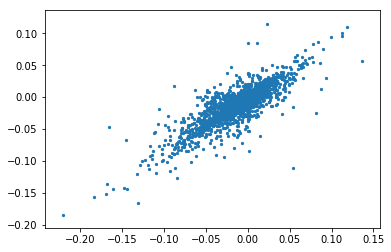

In [82]:
plt.scatter(comb['pi_mean'], comb['pi'], s=5)

# A549

In [ ]:
abundance_file = "/cellar/users/bpmunson/crappy/data/test_data/input_data/A549/A549_abundance_thresholds.txt"
counts_file = "/cellar/users/bpmunson/crappy/data/test_data/input_data/A549/A549_timepoint_counts.txt"
times = np.array([3,14,21,28])

# initialize screen object
screen = dual_crispr_screen.Screen(counts_file, times)

# set some parameters
# number of iterations to perform
screen.options.niter = 2
screen.options.null_target_id = '0'
screen.options.verbose = True

# perform construct fitness calculation
screen.run_construct_fitting()

# run bootstraps
screen.run_bootstrap()

# summarize results 
screen.summarize()

# view results 
screen.results.head()

In [ ]:
abundance_file = "/cellar/users/bpmunson/crappy/data/test_data/input_data/A549/A549_abundance_thresholds.txt"
counts_file = "/cellar/users/bpmunson/crappy/data/test_data/input_data/A549/A549_timepoint_counts.txt"
times = np.array([3,14,21,28])

# initialize screen object
screen = dual_crispr_screen.Screen(counts_file, times, abundance_file)

# set some parameters
# number of iterations to perform
screen.options.niter = 2
screen.options.null_target_id = '0'
screen.options.verbose = True

# perform construct fitness calculation
screen.run_construct_fitting()

# run bootstraps
screen.run_bootstrap()

# summarize results 
screen.summarize()

# view results 
screen.results.head()

In [ ]:
sampleName                     
testing_T3_1              3.025
testing_T3_2              3.525
testing_T14_1             5.525
testing_T14_2             3.025
testing_T21_1             4.525
testing_T21_2             3.025
testing_T28_1             3.025
testing_T28_2             3.525



sampleName                     
testing_T3_1           3.335947
testing_T3_2           3.475000
testing_T14_1          3.338280
testing_T14_2          4.089135
testing_T21_1          4.525000
testing_T21_2          4.325000
testing_T28_1          4.225000
testing_T28_2          3.575000

In [ ]:
2**3.025